In [179]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset3_v2 import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [192]:
# Overall settings
out_dir = "out"
batch_size = 1024

model_name = "ckpt_50pct_recursive_h100_v2.pt"
# folder_path = '../data/CL_experiments/test/inertia07_ki-0.0061-kp-11.8427'
# folder_path = '../data/CL_experiments/test/inertia04_ki-0.0061-kp-11.8427'
# folder_path = '../../../in-context-bldc/data/simulated/10_percent'
# folder_path = '../../../in-context-bldc/data/simulated/50_percent_longer_steps'
folder_path = '../data/CL_experiments_double_sensor/train/inertia13_ki-0.0061-kp-11.8427'
# folder_path = '../../../in-context-bldc-data/simulated/90_percent_with_alfa_beta_alt'

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/model_name, map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])
print(exp_data['best_val_loss'])
print(exp_data["cfg"])
print(exp_data["cfg"].lr)

True
100
5130
0.00044044961759936996
Namespace(model_dir='out', out_file='ckpt_50pct_recursive_h100_v2', in_file='ckpt_50pct_recursive_h100_v2', init_from='scratch', seed=42, log_wandb=False, nx=4, nu=5, ny=1, seq_len=100, mag_range=(0.5, 0.97), phase_range=(0.0, 1.5707963267948966), fixed_system=False, n_layer=8, n_head=4, n_embd=16, dropout=0, bias=False, batch_size=64, max_iters=20000, warmup_iters=5000, lr=5e-05, weight_decay=0.0, eval_interval=10, eval_iters=10, fixed_lr=False, threads=16, no_cuda=False, cuda_device='cuda:0', compile=False, beta1=0.9, beta2=0.95, block_size=100, lr_decay_iters=20000, min_lr=5e-06, decay_lr=True, eval_batch_size=64)
5e-05


In [182]:
# Expected rmse speed
# np.sqrt(exp_data['best_val_loss']) * 2500

In [183]:
# exp_data.keys()

number of parameters: 0.03M


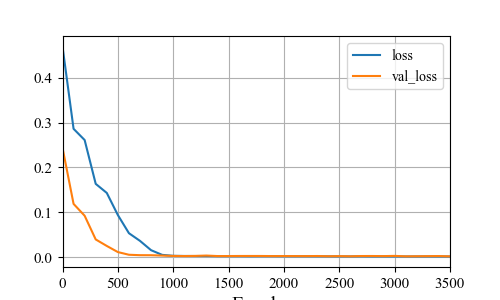

Model size in KB: 98.12890625


In [184]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

plt.figure(figsize=(5,3))
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS'][::100], label="loss")
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS_VAL'][::100], label="val_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

size_in_bytes = sum(param.numel() * param.element_size() for param in model.parameters())
size_in_bytes += sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())

# Convert bytes to kilobytes
size_in_kb = size_in_bytes / 1024
print('Model size in KB:', size_in_kb)

In [185]:
dfs = load_dataframes_from_folder(folder_path)
# Log the number of DataFrames loaded
print(f"Loaded {len(dfs)} DataFrames from {folder_path}.") 

# Create an instance of the dataset
dataset_exp = Dataset(dfs=dfs, seq_len=1000)
dataloader = DataLoader(dataset_exp, batch_size=batch_size, shuffle=True)

# df_idx = np.random.choice(len(dfs))
# df = dfs[df_idx]
# diff_array = df['r'].diff(-seq_len).to_numpy()
# diff_array = diff_array[~np.isnan(diff_array)]
# prob_ratio = 0.5 # ratio between constant samples and step samples
# if np.random.rand() >= prob_ratio:
#     good_idx = np.flatnonzero(diff_array == 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array != 0)
# else:
#     good_idx = np.flatnonzero(diff_array != 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array == 0)
# start_idx = np.random.choice(good_idx)
# batch_y = torch.tensor(df['omega'].iloc[start_idx:start_idx + seq_len].values, dtype=torch.float32)
# print(batch_y)


# Example of accessing an item
# batch_u, batch_y = next(iter(dataloader))
# batch_u, batch_y = batch_u.to(device), batch_y.to(device)
# batch_y_pred = torch.empty_like(batch_y)
# cputime = np.empty(batch_y.shape[1])

# b, tt, _ = batch_y.shape 
# print(b, tt)

Loaded 100 DataFrames from ../data/CL_experiments_double_sensor/train/inertia13_ki-0.0061-kp-11.8427.


In [186]:
H = exp_data["cfg"].seq_len


Average rmse:  306.52768325805664


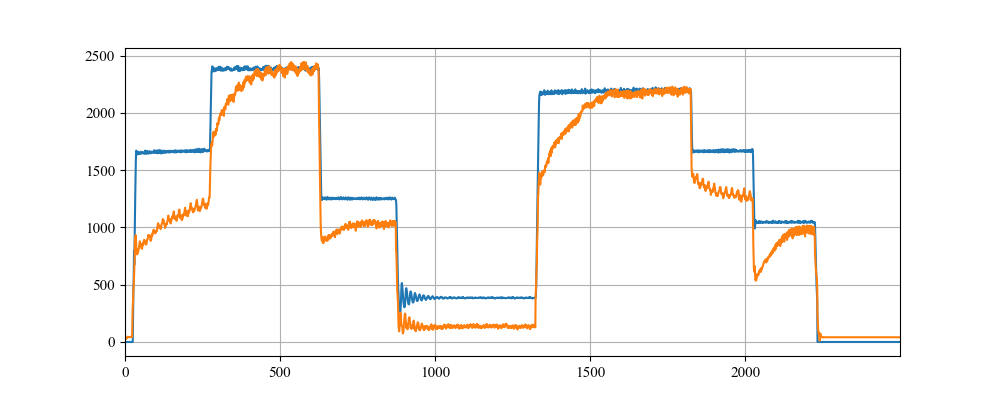

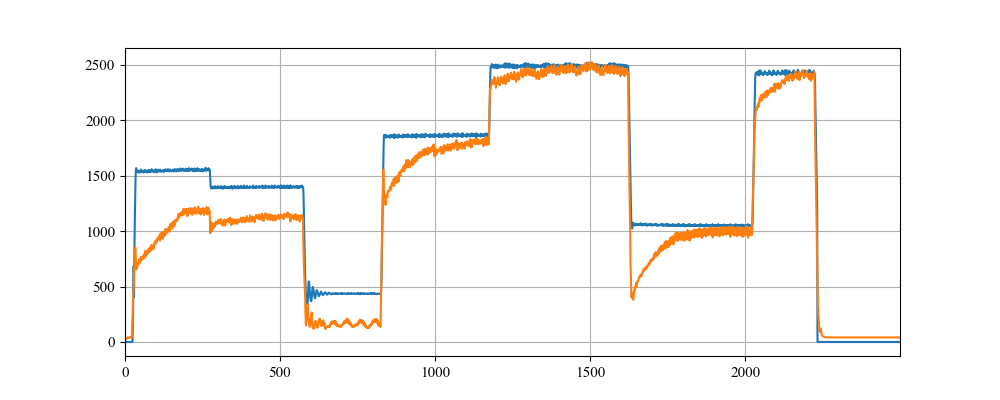

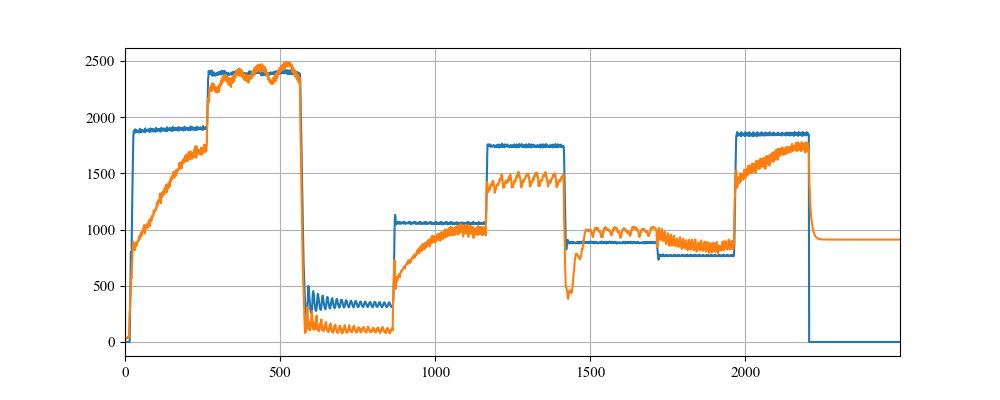

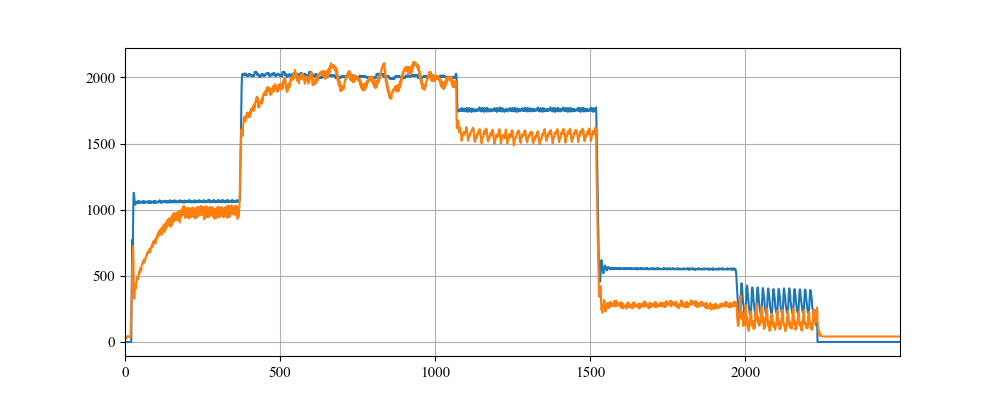

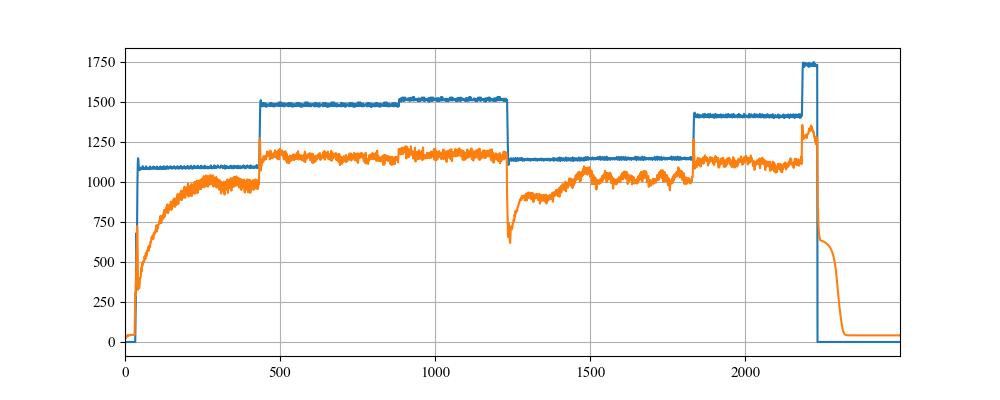

In [187]:
## test each experiment
df_len = len(dfs)
# df_len = 1
rmse = np.zeros(df_len)
u_full_all = []
y_full_all = []
# y_pred_all = []
for i in range(df_len):
    u_full, y_full = dataset_exp.get_full_experiment(i)
    u_full, y_full = u_full.to(device), y_full.to(device)
    # u_full = torch.stack([u_full], dim=0)
    # y_full = torch.stack([y_full], dim=0)
    # cputime = np.empty(y_full.shape[1])
    # y_pred = torch.empty_like(y_full)

    u_full_all.append(u_full)
    y_full_all.append(y_full)

u_full_all = torch.stack(u_full_all, dim=0)
y_full_all = torch.stack(y_full_all, dim=0)
y_pred_all = torch.empty_like(y_full_all)
last_omega = torch.zeros((df_len, H, 1))  


# print(u_full_all.shape)
# print(y_full_all.shape[1])
# print(last_omega.shape)



with torch.no_grad():

    for j in range(y_full_all.shape[1]):
        # print(last_omega[:,-3,0], last_omega[:,-2,0], last_omega[:,-1,0])
        
        # at time instant j
        if j < H:
            input_val = u_full_all[:, :j+1, :]
            input_val[:, :j+1, 4] = last_omega[:,-j-1:,0]

            pred = model(input_val)
        else:
            input_val = u_full_all[:,j-H+1:j+1, :]
            # print(input_val.shape)
            # print(input_val[:,:, 4].shape)
            # print(last_omega.shape)
            input_val[:,:, 4] = last_omega[:,:,0]

            pred = model(input_val)
        
        # cputime[i] = time.time() - start
        y_pred_all[:,j,0] = pred[:,-1,0]
        # last_omega[:,0:-2,0] = last_omega[:,1:-1,0]
        last_omega = torch.roll(last_omega, -1, 1)
        last_omega[:,-1,0] = y_pred_all[:,j,0]
        
        # print(cputime[i])
    
    u_full_all, y_full_all, y_pred_all  = reverse_normalization(u_full_all, y_full_all, y_pred_all)

for i in range(df_len):
    y_tmp = y_full_all[i,:,:].cpu().numpy()
    y_pred_tmp = y_pred_all[i,:,:].cpu().numpy()
    # print(y_tmp)
    # print(y_pred_tmp)
    rmse[i] = np.sqrt(((y_tmp-y_pred_tmp)**2).mean())

print("Average rmse: ", rmse.mean())

for i in range(5):

    y_full_np = y_full_all.cpu().numpy()  # Shape (seq_len, 1)
    y_pred_np = y_pred_all.cpu().numpy()
    # print(y_full_np.shape)
    plt.figure(figsize=(10,4))
    plt.plot(y_full_np[i])
    plt.plot(y_pred_np[i])
    plt.show()
    